# Table of Contents
* [1. Objectives and goals](#1.-Objectives-and-goals)
	* [1.1 Problem statement](#1.1-Problem-statement)
* [2. Training splice junction classifier](#2.-Training-splice-junction-classifier)
	* [2.1 Dataset](#2.1-Dataset)
	* [2.2 Attributes and features extraction](#2.2-Attributes-and-features-extraction)
	* [2.3 Models and optimization options](#2.3-Models-and-optimization-options)
* [3. Trained models evaluation](#3.-Trained-models-evaluation)
* [4. Using a splice junction classifier](#4.-Using-a-splice-junction-classifier)
	* [4.1 Decoding method](#4.1-Decoding-method)
	* [4.2 Decoding performance](#4.2-Decoding-performance)
* [5. Literature & references](#5.-Literature-&-references)


In [2]:
# first we define relevant directories
import sys
# in case PySeqLab package is not installed, 
# we can download the package repository from https://bitbucket.org/A_2/pyseqlab
# and then we add the location of the repository to the python system path
# location of the PySeqLab repository on disk -- INSERT location or discard if PySeqLab package is already installed
pyseqlab_package_dir = ""
sys.path.insert(0, pyseqlab_package_dir)
import os
# splice-junction directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# src directory under splice-junction folder -- check the tree path (below)
src_dir = os.path.join(project_dir, 'src')
sys.path.insert(0, src_dir)
# get the tutorials dir
tutorials_dir = os.path.join(project_dir, 'tutorials')
# to use for customizing the display/format of the cells
from IPython.core.display import HTML
with open(os.path.join(tutorials_dir, 'pseqlab_base.css')) as f:
    css = "".join(f.readlines())
HTML(css)


# 1. Objectives and goals

In this tutorial, we will learn about:
<ul>
<li> the process/workflow for building Eukaryotic splice-junction sequences predictor (i.e. based on CRFs model formalism)</li>
<li> training the built model and evaluating its performance</li>
<li> reviving the trained model and decoding new sequences (i.e. test sequences that were not used for training)</li>
</ul>

## 1.1 Problem statement

Determining the intron/exon boundaries in a given DNA nucleotide sequence is important for understanding  RNA synthesis and protein translation. Introns are spliced in the precursor mRNA phase where exons are concatenated to produce the mature mRNA that would translate to protein in a later phase. Hence, given a nucleotide sequence, the goal is to predict/recognize if it represents an (1) intron/exon (acceptors) boundary (IE), (2) exon/intron (donors) boundary (EI) or (3) neither of the two (N).

In order to do so, we used a <a href="http://archive.ics.uci.edu/ml/datasets/Molecular+Biology+%28Splice-junction+Gene+Sequences%29">publicly available dataset</a> that was constructed for testing machine learning approaches for this task. The dataset  includes a set of DNA sequences (60 nucleotides long) with labeled donor (EI) and acceptor sites (IE). The number of instances is 751 with IE label and 745 as EI label. Negative samples were constructed using similarly sized windows that did not cross the intron/exon boundary, sampled at random from the later sequences (Towell et al. 1992). The total number of sequences is 3190.  However, after inspecting and processing the sequences we identified 12 duplicates and thus we worked with 3178 sequences.

<strong>Our approach</strong>: We modeled the task as a "switch" problem. That is, whenever there was a switch (i.e intron/exon or exon/intron) we assigned a label to the switch where the change occurred. Because of the structure of the sequences in the dataset, the switch occurs at the 31st position in every sequence. We assigned label <code class="pseq_code">"1"</code> for the switch from intron to exon, label <code class="pseq_code">"2"</code> for the switch from exon to intron and <code class="pseq_code">"0"</code> when no switch occurred.  Additionally, we added/augmented to the nucleotides letters (i.e. A, C, T, G, etc.) their position in the sequence. The position started from left to right and counting from 1 to 60. The combined letter and position number formed the main track that we used for building our model. We will refer to this track throughout this tutorial by <a id="spljun_track"></a><strong><code class="pseq_code">num_obs</code></strong>.


<strong><em>Reminder</em></strong>: To work with this tutorial interactively, we need first to clone the <a href="https://bitbucket.org/A_2/splice_junction_prediction">splice-junction repository from bitbucket</a> to our disk locally. Then, navigate to <strong>[cloned_package_dir]/tutorials</strong> where <strong>[cloned_package_dir]</strong> is the path to the cloned package folder. The structure of the repository will be:
<pre style="font-size:0.8em;">
</pre>

<strong><span style="color:red;">NB: </span></strong> <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> should be already installed or included in the python system path before we proceed.

# 2. Training splice junction classifier

The <code class="pseq_code">src</code> directory in the cloned repository includes three main modules: 
<ul>
<li><code class="pseq_code">process_dataset.py</code></li>
<li><code class="pseq_code">splice_junction_attribute_extractor.py </code></li>
<li><code class="pseq_code">train_splicejunction_predictor_workflow.py </code></li>
</ul>
 
As a prerequisite, refer to <a href="http://pyseqlab.readthedocs.io/en/latest/methods_tutorials.html">these tutorials</a> describing in detail the model building and training process using PySeqLab package.


## 2.1 Dataset

We performed a stratified 5-fold cross validation where the dataset was divided into five training files with their corresponding five testing files. We used the functions implemented in <code class="pseq_code">process_dataset.py</code> module. By simply running <code class="pseq_function">prepare_dataset()</code> function, the training and testing files will be generated automatically. For reproducibility purpose, we will use the 5-fold division (found under <code class="pseq_code">5-fold folder</code> in <code class="pseq_code">dataset</code> directory) that we already used for the trained models dumped in this repository.

In our current setting, our dataset is composed of five folds, each has a training and test file found in the <code class="pseq_code">dataset</code> folder:
<pre style="font-size:0.9em">
├── dataset
│   ├── 5-fold
│   │   ├── test_f_0.txt
│   │   ├── test_f_1.txt
│   │   ├── test_f_2.txt
│   │   ├── test_f_3.txt
│   │   ├── test_f_4.txt
│   │   ├── train_f_0.txt
│   │   ├── train_f_1.txt
│   │   ├── train_f_2.txt
│   │   ├── train_f_3.txt
│   │   ├── train_f_4.txt
</pre>

## 2.2 Attributes and features extraction

We start by defining our attribute extractor that we will use to generate attributes from the parsed sequences. Our attribute extractor <code class="pseq_class">SpliceJunctionAttributeExtractor</code> is subclass of <code class="pseq_class">GenericAttributeExtractor</code> class implemented in <code class="pseq_code">splice_junction_attribute_extractor.py</code> module. It defines attributes based on the <code class="pseq_code">num_obs</code> track we defined earlier (<a href="#spljun_track">see here</a>) at each position in the sequence. Below is <a href="#spljun_attrext_demo">an example</a> of the extracted attributes using our <code class="pseq_class">SpliceJunctionAttributeExtractor</code> class from a sequence in our training file. 

After defining our attribute extractor, we define the feature templates that are used by the feature extractors to generate features. Feature templates and feature extraction are described in detail in <a href="http://pyseqlab.readthedocs.io/en/latest/_static/templates_and_features_extraction.html">this tutorial</a>.

In the <code class="pseq_code">train_splicejunction_predictor_workflow.py</code> module, we define our feature templates using <code class="pseq_function">template_config()</code> function.

<pre style="font-size:0.75em">
def template_config():
    template_generator = TemplateGenerator()
    templateXY = {}
    template_generator.generate_template_XY('num_obs', 
                                            ('1-gram:2-gram:3-gram:4-gram:5-gram:6-gram', range(-15, 16)),
                                            '1-state', 
                                            templateXY)
    templateY = template_generator.generate_template_Y('2-states')
    return(templateXY, templateY)
</pre>

The defined templates include only one track (i.e. <code class="pseq_code">num_obs</code>) representing the numbered position nucleotide letter. <br/>

<ul><li>We define a window of size 31 centered at each position in the sequence. That is, we pass through the sequence from left to right, where at each position, we construct a window of size 31 (a window that includes attributes from 15 previous positions, current position,  and 15 forward/future positions)</li>
<li>We extract 1 to 6 grams (i.e. <code class="pseq_code">1-gram:2-gram:3-gram:4-gram:5-gram:6-gram</code>) in the specified window </li>
<li>We join these attributes with the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>

For the <code class="pseq_code">Y labels only</code>:
<ul><li>We use two states (i.e. label transitions). That is, we pass through the sequence from left to right, where at each position, we extract the previous and current labels.
</li></ul>

## 2.3 Models and optimization options

In the <code class="pseq_code">train_splicejunction_predictor_workflow.py</code> module, we implement the training workflow. In this section, we describe the training setup and the chosen options for performing the training.

We used the following classes:
<ul><li>feature extractor (<code class="pseq_class">HOFeatureExtractor)</code>,</li>
<li>CRFs model (<code class="pseq_class">HOCRFAD</code>) and</li>
<li>CRFs model representation (<code class="pseq_class">HOCRFADModelRepresentation</code>)</li>
</ul>


For the training method (i.e. optimization options), we used the following options:
<ul><li>stochastic gradient ascent (<code class="pseq_code">method = SGA</code>),</li>
<li>with l2 regularization (<code class="pseq_code">regularization_type = l2</code>) and regularization value equal to 1 (<code class="pseq_code">regularization_value = 1</code>), </li>
<li>and 5 passes through the training data (<code class="pseq_code">num_epochs = 5</code>)</li>
</ul>

To run the training process, we use <code class="pseq_function">run_training(optimization_options, template_config)</code> function. We pass the optimization options and the function generating the defined feature templates (<a href="#spljun_trainmodel">see this code snippet</a>). The training process will perform the following:
<ul>
<li> Loop through each fold (i.e. from 0 to 4)
<ol>
<li> read the training file corresponding to the current fold (i.e. <code class="pseq_code">train_f_0.txt</code>) and parse it into sequences</li>
<li> process and dump the parsed sequences on disk in a relevant format for the learning framework </li>
<li> build a model based on the processed training sequences </li>
<li> train the model weights (i.e. estimate the feature weights) using the specified optimization method</li>
<li> use the trained model to decode the training sequences and write the result to a file</li>
<li> read the test file corresponding to the current fold (i.e. <code class="pseq_code">test_f_0.txt</code>) and parse it into sequences</li>
<li> use the trained model to decode the testing sequences and write the result to a file</li>
<li> return the path to the trained model directory </li>
</ol>
</li>
</ul>

The return value of the training function (i.e. <code class="pseq_code">res</code> -- <a href="#spljun_trainmodel">see code snippet below</a>) is a list of tuples, where each tuple has the following structure:
<ol>
<li>first entry will be the path to the trained model on disk</li>
<li>second entry will be the performance of the trained model using the training file </li>
<li>third entry will be the performance of the trained model using the test file </li>
</ol>

The performance evaluation while using the trained model is reported based on the single nucleotide decoding (as in <a href="#spljun_trainmodel">the code snippet below</a>). Moreover, we track the estimated average log-likelihood for each model  by plotting the generated <code class="pseq_code">avg_loglikelihood_training</code> files. 

<a id="spljun_attrext_demo"></a>

In [12]:
from splice_junction_attribute_extractor import *
seq = example()

attr_desc {'num_obs': {'description': 'numbered nucleotides observation  (i.e. nucleotide letter concatenated with the position)', 'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <splice_junction_attribute_extractor.SpliceJunctionAttributeExtractor object at 0x7f1100d7a9e8>>, 'encoding': 'categorical'}, 'obs': {'description': 'nucleotides observation', 'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <splice_junction_attribute_extractor.SpliceJunctionAttributeExtractor object at 0x7f1100d7a9e8>>, 'encoding': 'categorical'}}
boundary (16, 16)
attributes {'num_obs': 'T16', 'obs': 'T'}
boundary (43, 43)
attributes {'num_obs': 'A43', 'obs': 'A'}
boundary (29, 29)
attributes {'num_obs': 'A29', 'obs': 'A'}
boundary (6, 6)
attributes {'num_obs': 'A6', 'obs': 'A'}
boundary (33, 33)
attributes {'num_obs': 'A33', 'obs': 'A'}
boundary (31, 31)
attributes {'num_obs': 'C31', 'obs': 'C'}
boundary (20, 20)
attributes {'num_obs': '

<a id="spljun_trainmodel"></a>

1 sequences have been processed
2 sequences have been processed
3 sequences have been processed
4 sequences have been processed
5 sequences have been processed
6 sequences have been processed
7 sequences have been processed
8 sequences have been processed
9 sequences have been processed
10 sequences have been processed
dumping globalfeatures -- processed seqs:  1
dumping globalfeatures -- processed seqs:  2
dumping globalfeatures -- processed seqs:  3
dumping globalfeatures -- processed seqs:  4
dumping globalfeatures -- processed seqs:  5
dumping globalfeatures -- processed seqs:  6
dumping globalfeatures -- processed seqs:  7
dumping globalfeatures -- processed seqs:  8
dumping globalfeatures -- processed seqs:  9
dumping globalfeatures -- processed seqs:  10
constructing model -- processed seqs:  1
constructing model -- processed seqs:  2
constructing model -- processed seqs:  3
constructing model -- processed seqs:  4
constructing model -- processed seqs:  5
constructing model -- p

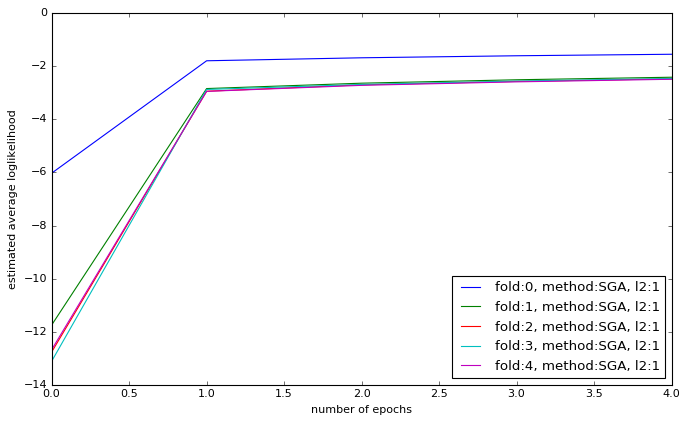

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
from pyseqlab.utilities import ReaderWriter
# import the module containing training workflow
# we use only 10 sequences for demonstration
# to go through the whole file simply omit passing the num_seqs keyword argument
num_seqs = 10
from train_splicejunction_predictor_workflow import *
optimization_options = {"method" : "SGA",
                        "regularization_type": "l2",
                        "regularization_value":1,
                        "num_epochs":5,
                        "tolerance":1e-6
                        }

# demonstrate training using only 10 sequences from the both the training and test file
# NB: the performance evaluation reported during training is based on the single nucleotide accuracy/decoding error
res = run_training(optimization_options, template_config, num_seqs=10)
models_dir = [elem[0] for elem in res]

# using all sequences from the both the training and test file
# NB: the performance evaluation reported during training is based on the single nucleotide accuracy/decoding error
# res = run_training(optimization_options, template_config)
# evaluating the performance of the models
# models_dir = [elem[0] for elem in res]
# error_score = eval_models(models_dir)

def plot_avgloglikelihood(models_dir):
    # plot the estimated average loglikelihood
    for fold in range(len(models_dir)):
        model_dir=models_dir[fold]
        avg_ll = ReaderWriter.read_data(os.path.join(model_dir, 'avg_loglikelihood_training'))
        plt.plot(avg_ll[1:], label="fold:{}, method:{}, {}:{}".format(fold,
                                                                      optimization_options['method'], 
                                                                      optimization_options['regularization_type'],
                                                                      optimization_options['regularization_value']))
    plt.legend(loc='lower right')
    plt.xlabel('number of epochs')
    plt.ylabel('estimated average loglikelihood')
# optimization option used to train the models
optimization_options={'method':'SGA', 'regularization_type':'l2', 'regularization_value':1}
plot_avgloglikelihood(models_dir)

# 3. Trained models evaluation

<strong><span style="color:red">NB</span></strong>: Before proceeding, we have to unzip the <code class="pseq_code">trained_models</code> directory so that we can explore and assess the trained models.

To evaluate the performance of the trained models, we will use the <code class="pseq_function">eval_models(args)</code> function in the <code class="pseq_code">train_splicejunction_predictor_workflow.py</code> module. It takes a list of the trained models' path on disk. An example of a trained model directory will have the following structure:

<pre style="font-size:0.8em;">
├── avg_loglikelihood_training
├── crf_training_log.txt
├── decoding_seqs
│   ├── test_fold_0.txt
│   ├── train_fold_0.txt
├── model_parts
│   ├── class_desc.txt
│   ├── FE_templateX
│   ├── FE_templateY
│   ├── MR_L
│   ├── MR_modelfeatures
│   ├── MR_modelfeaturescodebook
│   ├── MR_Ycodebook
│   ├── weights
</pre>

Each model has a <code class="pseq_code">model_parts</code> folder. The decoded sequences are found under <code class="pseq_code">decoding_seqs</code> folder where we have the decoding of the training and test files. We evaluate the performance of the trained models by evaluating the decoding error using those files. 
The splice-junction prediction task requires to assign one label to the whole sequence (i.e. 60 nucleotides) as opposed to one label for each nucleotide. Hence, the <code class="pseq_function">eval_models(args)</code> function is implemented to evaluate the performance for assigning one label to the whole sequence rather than single nucleotide (as in the code snippet below). 

In [9]:
import numpy
# to evaluate the models' performance on the sequence level, using already trained models
# eval_models takes a list of trained models path on disk
trainedmodels_rootdir = os.path.join(project_dir, 'trained_models')
models_folders = ("2017_5_5-10_38_38_3987",  
                  "2017_5_5-11_59_56_390744",
                  "2017_5_5-13_8_2_735679",
                  "2017_5_5-14_4_13_716529",
                  "2017_5_5-15_0_45_409499")
models_dir = [os.path.join(trainedmodels_rootdir, folder) for folder in models_folders]
error_score = eval_models(models_dir)
print("decoding error score for the trained models:")
print(error_score)
print()
print("average deocding error across the trained models: ", numpy.mean(error_score))

train_fold_0.txt
                                                              precision    recall  f1-score   support

000000000000000000000000000000000000000000000000000000000000       1.00      1.00      1.00      1323
000000000000000000000000000000100000000000000000000000000000       1.00      1.00      1.00       610
000000000000000000000000000000200000000000000000000000000000       1.00      1.00      1.00       608

                                                 avg / total       1.00      1.00      1.00      2541

weighted f1:
0.999606367068
micro f1:
0.999606454152
test_fold_0.txt
                                                              precision    recall  f1-score   support

000000000000000000000000000000000000000000000000000000000000       0.96      0.97      0.96       328
000000000000000000000000000000100000000000000000000000000000       0.96      0.94      0.95       157
000000000000000000000000000000200000000000000000000000000000       0.95      0.95      0.95   

<a id="conll_evalmodel"></a>

# 4. Using a splice junction classifier

In this section, we demonstrate how to revive a trained model for splice junction prediction and use it to decode a file comprising new/unseen sequences (i.e. test sequences).

As a reminder, the trained models (including their components) are found under <code class="pseq_code">trained_models </code>folder in the cloned repository. We have to unzip them first before proceeding.

To use/revive a trained model dumped on disk, we use <code class="pseq_function">revive_learnedmodel(args)</code> function. It takes the path to the trained models' directory.

In [14]:
# we get the trained model parts directory -- check the tree path in the cell above
trained_model_dir = os.path.join(project_dir, 'trained_models')
# loading the trained model
crf_m = revive_learnedmodel(os.path.join(trained_model_dir, '2017_5_5-13_8_2_735679'))

After we have revived our model, we will use a test dataset from the ones in the 5-fold directory. Just as a reminder, the tree path is:
<pre style="font-size:0.9em">
├── dataset
│   ├── 5-fold
│   │   ├── test_f_0.txt
│   │   ├── test_f_1.txt
│   │   ├── test_f_2.txt
│   │   ├── test_f_3.txt
│   │   ├── test_f_4.txt
│   │   ├── train_f_0.txt
│   │   ├── train_f_1.txt
│   │   ├── train_f_2.txt
│   │   ├── train_f_3.txt
│   │   ├── train_f_4.txt
</pre>

The test dataset is composed of multiple sequences that are separated by a newline. An excerpt of the sequences in the train_f_0.txt file is provided below:
<pre style="font-size:0.8em;">
id	obs	label
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	G	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	T	0
AGMKPNRSB-NEG-1	A	0
AGMKPNRSB-NEG-1	C	0
AGMKPNRSB-NEG-1	A	0

AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	C	0
AGMORS12A-NEG-181	A	0
AGMORS12A-NEG-181	T	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0
AGMORS12A-NEG-181	G	0

AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	G	0
AGMORS9A-NEG-481	G	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	G	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	G	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	G	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	A	0
AGMORS9A-NEG-481	G	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	G	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	C	0
AGMORS9A-NEG-481	T	0
AGMORS9A-NEG-481	G	0

AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	C	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	C	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	C	0
AGMRSKPNI-NEG-1141	C	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	C	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	C	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	C	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	C	0
AGMRSKPNI-NEG-1141	T	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	G	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0
AGMRSKPNI-NEG-1141	A	0

ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	A	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	A	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	T	1
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	A	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	A	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	G	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	C	0
ATRINS-ACCEPTOR-1678	T	0
ATRINS-ACCEPTOR-1678	A	0

ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	A	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	A	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	A	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	G	1
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	A	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	A	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	C	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	T	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	G	0
ATRINS-ACCEPTOR-701	A	0

ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	G	2
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	A	0
ATRINS-DONOR-521	G	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	C	0
ATRINS-DONOR-521	T	0
ATRINS-DONOR-521	G	0
</pre>

To read the file, we will use <code class="pseq_class">DataFileParser</code> class in the <code class="pseq_code">utilities</code> module. 

In [15]:
from pyseqlab.utilities import DataFileParser
# initialize a data file parser
dparser = DataFileParser()
# provide the options to parser such as the header info, the separator between words and if the y label is already existing
# main means the header is found in the first line of the file
header = "main"
# y_ref is a boolean indicating if the label to predict is already found in the file
y_ref = True
# spearator between the observations
column_sep = "\t"
seqs = []
for seq in dparser.read_file(os.path.join(project_dir, 'dataset', '5-fold','test_f_2.txt'), header, y_ref=y_ref, column_sep = column_sep):
    seqs.append(seq)
    
# printing one sequence for display
print(seqs[0])
print("number of parsed sequences is: ", len(seqs))

Y sequence:
 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
X sequence:
 {1: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'C'}, 2: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'C'}, 3: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'C'}, 4: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'C'}, 5: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'C'}, 6: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'A'}, 7: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'T'}, 8: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'T'}, 9: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'C'}, 10: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'T'}, 11: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'C'}, 12: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'G'}, 13: {'id': 'HUMGASTA-ACCEPTOR-6600', 'obs': 'C'}, 14: {'id': 'HUMGASTA-ACCEPTOR-6

## 4.1 Decoding method

Then, we specify the decoding options for our model to use. The main method for decoding is <code class="pseq_method">decode_seqs(decoding_method, out_dir, **kwargs)</code> that takes two arguments and multiple keyword arguments. 
<br/>

The obligatory arguments are:
<ol>
<li>
<code class="pseq_args">decoding_method</code>: string representing the decoding method such as <code class="pseq_code">'viterbi'</code>
</li>
<li>
<code class="pseq_args">output_dir</code>: string, the output directory representing the path where the parsing would take place
</li>
</ol>

For the keyword arguments, the main ones to specify are:
<ul>
<li>
<code class="pseq_args">seqs</code>: the list of sequences we already parsed/read from the text file we need to label
</li>
<li>
<code class="pseq_args">file_name</code>: the name of the file where decoded sequences will be written to (it is optional)
</li>
<li>
<code class="pseq_args">sep</code>: the separator between the columns/observations when writing decoded sequences to the specified file using <code class="pseq_args">file_name</code> keyword argument
</li>
</ul>

In [16]:
decoding_method = 'viterbi'
output_dir = os.path.join(project_dir, 'tutorials')
sep = "\t"
# decode sequences
seqs_decoded = crf_m.decode_seqs(decoding_method, output_dir, seqs= seqs, file_name = 'tutorial_seqs_decoding.txt', sep=sep)

identifying model active features -- processed seqs:  1
identifying model active features -- processed seqs:  2
identifying model active features -- processed seqs:  3
identifying model active features -- processed seqs:  4
identifying model active features -- processed seqs:  5
identifying model active features -- processed seqs:  6
identifying model active features -- processed seqs:  7
identifying model active features -- processed seqs:  8
identifying model active features -- processed seqs:  9
identifying model active features -- processed seqs:  10
identifying model active features -- processed seqs:  11
identifying model active features -- processed seqs:  12
identifying model active features -- processed seqs:  13
identifying model active features -- processed seqs:  14
identifying model active features -- processed seqs:  15
identifying model active features -- processed seqs:  16
identifying model active features -- processed seqs:  17
identifying model active features -- pro

## 4.2 Decoding performance

The decoded sequences will be found under the <code class="pseq_code">tutorials</code> directory (i.e. current directory) under <code class="pseq_code">decoding_seqs</code> directory.
<pre style="font-size:0.8em;">
|---tutorials
|      |---decoding_seqs
|      |             |---tutorial_seqs_decoding.txt
</pre>
The <code class="pseq_code">tutorial_seqs_decoding.txt</code> file will follow the same template/format of the <code class="pseq_code">test_f_2.txt</code> file we already parsed earlier, but this time with additional column containing our model's predictions.
We evaluate the decoding performance this time using <code class="pseq_function">eval_decoded_file(args)</code> function in <code class="pseq_code">train_splicejunction_predictor_workflow.py</code> module. It takes the path to the newly decoded file as an argument and returns the decoding error.

In [17]:
new_decseqs_file = os.path.join(tutorials_dir, 'decoding_seqs','tutorial_seqs_decoding.txt')
score = eval_decoded_file(new_decseqs_file)

print("error score: ", score)

                                                              precision    recall  f1-score   support

000000000000000000000000000000000000000000000000000000000000       0.97      0.97      0.97       331
000000000000000000000000000000100000000000000000000000000000       0.95      0.96      0.96       151
000000000000000000000000000000200000000000000000000000000000       0.97      0.97      0.97       153

                                                 avg / total       0.97      0.97      0.97       635

weighted f1:
0.968514485113
micro f1:
0.968503937008
error score:  0.0314960629921


Our model achieves a decoding error score equal to 3.1% <br/>
Exploring and experimenting with different feature templates and attributes for training a model are left as an exercise for the readers ... :)


# 5. Literature & references

M. O. Noordewier and G. G. Towell and J. W. Shavlik, 1991; "Training Knowledge-Based Neural Networks to Recognize Genes in DNA Sequences". Advances in Neural Information Processing Systems, volume 3, Morgan Kaufmann. 

G. G. Towell and J. W. Shavlik, 1992; "Interpretation of Artificial Neural Networks: Mapping Knowledge-based Neural Networks into Rules", In Advances in Neural Information Processing Systems, volume 4, Morgan Kaufmann. 
